<a href="https://colab.research.google.com/github/gduncan2/CS445_OpticalFlowProj/blob/main/445FinalProj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import cv2
import numpy as np
import os
import csv
import matplotlib.pyplot as plt

In [8]:
def play_video(video, fps):
    while (video.isOpened()):
        retval, frame = video.read()
        if retval:
            cv2.imshow("Video", frame)
            val = cv2.waitKey(int(1000/fps))
            if val == 27:
                break
        else:
            break
    video.release()
    cv2.destroyAllWindows()

def write_video(filename, frames, fps):
    output = cv2.VideoWriter(filename, cv2.VideoWriter_fourcc(*'XVID'), fps, (frames[0].shape[1], frames[0].shape[0]), True)
    for frame in frames:
        output.write(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    output.release()

def get_video_frames(video):
    frames = []
    while(video.isOpened()):
        retval, frame = video.read()
        if retval:
            frames.append(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
        else:
            break
    return frames

In [9]:
cv2.destroyAllWindows()

In [4]:
cv2.destroyAllWindows()
video = cv2.VideoCapture('./media/roadrunner.mp4')
frames = get_video_frames(video)
write_video("./outputs/roadrunner_restored.mp4", frames, 30)



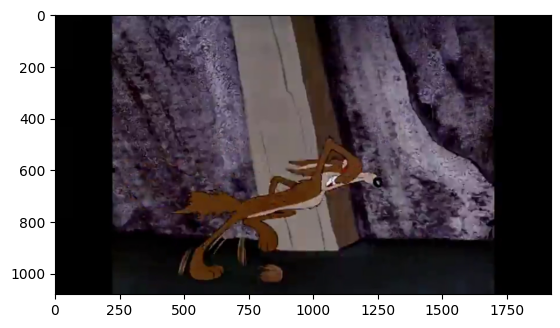

In [6]:
plt.imshow(frames[5])

In [10]:
def save_half_frames(frames):
    os.makedirs('./outputs/even_frames', exist_ok=True)
    os.makedirs('./outputs/odd_frames', exist_ok=True)

    even_frames = []
    odd_frames = []

    for i, frame in enumerate(frames):
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        if i % 2 == 0:
            even_frames.append(frame)
            cv2.imwrite(f"./outputs/even_frames/frame_{i:04d}.png", frame_bgr)
        else:
            odd_frames.append(frame)
            cv2.imwrite(f"./outputs/odd_frames/frame_{i:04d}.png", frame_bgr)

    print(f"Saved {len(even_frames)} even frames and {len(odd_frames)} odd frames.")

In [11]:
cv2.destroyAllWindows()
video = cv2.VideoCapture("./media/roadrunner.mp4")
frames = get_video_frames(video)
print(f"Number of frames extracted: {len(frames)}")
# save_half_frames(frames) # Saves the frames in the folders

Number of frames extracted: 291


In [3]:
def load_saved_frames(folder):
    frame_files = sorted([f for f in os.listdir(folder) if f.endswith('.png')])
    loaded_frames = []

    for file in frame_files:
        path = os.path.join(folder, file)
        frame = cv2.imread(path)
        if frame is not None:
            loaded_frames.append(frame)

    print(f"Loaded {len(loaded_frames)} frames from '{folder}'")
    return loaded_frames

In [5]:
def compare_frames_opencv_only(even_frames, odd_frames):
    comparisons = min(len(odd_frames), len(even_frames) - 1)

    for i in range(comparisons):
        prev_even = even_frames[i]
        next_even = even_frames[i + 1]
        target_odd = odd_frames[i]

        interpolated = cv2.addWeighted(prev_even, 0.5, next_even, 0.5, 0)

        diff = cv2.absdiff(interpolated, target_odd)
        diff_mean = cv2.mean(diff)[:3]

        interp_rgb = cv2.cvtColor(interpolated, cv2.COLOR_BGR2RGB)
        target_rgb = cv2.cvtColor(target_odd, cv2.COLOR_BGR2RGB)
        diff_rgb = cv2.cvtColor(diff, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(15, 5))
        plt.suptitle(f"Comparison #{i+1} — Mean Abs Diff (BGR): {diff_mean}")

        plt.subplot(1, 3, 1)
        plt.imshow(interp_rgb)
        plt.title("Interpolated (Even Avg)")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(target_rgb)
        plt.title("Ground Truth (Odd)")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(diff_rgb)
        plt.title("Difference")
        plt.axis('off')

        plt.show()

        # Remove to see all frames:
        break

Loaded 146 frames from './outputs/even_frames'
Loaded 145 frames from './outputs/odd_frames'


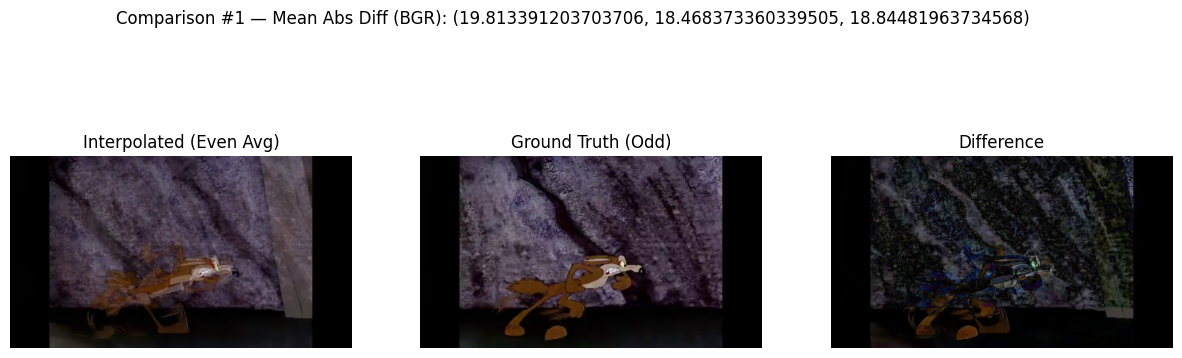

In [12]:
even_frames = load_saved_frames('./outputs/even_frames')
odd_frames = load_saved_frames('./outputs/odd_frames')

compare_frames_opencv_only(even_frames, odd_frames)

In [ ]:
# Preprocessing

# Note: Brightness equalization doesn't work well with certain frames (Around even_frames[50])
def preprocess(frame, size):
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2YUV)
    img[:,:,0] = cv2.equalizeHist(img[:,:,0])
    img = cv2.cvtColor(img, cv2.COLOR_YUV2BGR)
    img = cv2.GaussianBlur(img, (size,size), 0)
    return img


In [59]:
even_preprocess = []
odd_preprocess = []
for frame in even_frames:
    even_preprocess.append(preprocess(frame[:,250:1500], 41))
for frame in odd_frames:
    odd_preprocess.append(preprocess(frame[:,250:1500], 41))

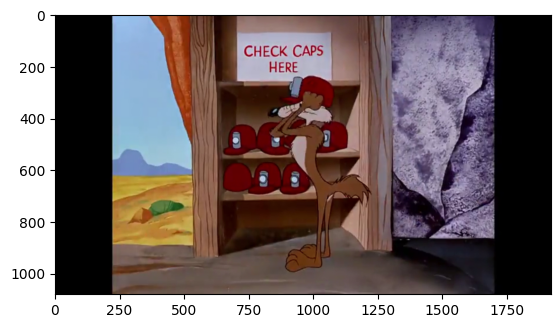

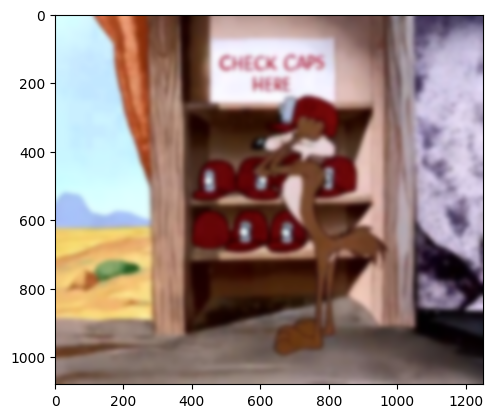

In [66]:
plt.figure()
plt.imshow(cv2.cvtColor(even_frames[100], cv2.COLOR_BGR2RGB))
plt.figure()
plt.imshow(cv2.cvtColor(even_preprocess[100], cv2.COLOR_BGR2RGB))

In [11]:
def result_interpretation(result, out_dir="result_output"): # anything csv related was chat gpt written, idk file io very well
    # Expands upon compare_frames_opencv_only written by Soham to write detailed data for each frame to a csv and output directory
    os.makedirs(out_dir, exist_ok=True)

    for folder in [
        "diffs_gen_vs_interp", 
        "diffs_gen_vs_reals", 
        "diffs_interp_vs_reals"
    ]:
        os.makedirs(os.path.join(out_dir, folder), exist_ok=True)

    csv_path = os.path.join(out_dir, "frame_metrics.csv")

    total_mean_sum = np.zeros(3)
    interp_mean_sum = 0
    worst_mean_val = -1
    worst_mean_idx = -1
    worst_mean_triplet = None

    with open(csv_path, mode="w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            "frame_index",

            "mean_gen_vs_interp_R", "G", "B",
            "mean_gen_vs_reals_R", "G", "B",
            "mean_interp_vs_reals_R", "G", "B",

            "diff_gen_vs_interp_path",
            "diff_gen_vs_reals_path",
            "diff_interp_vs_reals_path"
        ])

        for i in range(1, len(result) - 1, 2):
            gen = result[i]
            prev_real = result[i - 1]
            next_real = result[i + 1]
            interp = cv2.addWeighted(prev_real, 0.5, next_real, 0.5, 0)

            # Generated vs Interpolation
            diff_gen_interp = cv2.absdiff(gen, interp)
            mean_gen_interp = cv2.mean(diff_gen_interp)[:3]
            path_diff_gen_interp = f"diffs_gen_vs_interp/frame_{i}.png"
            cv2.imwrite(os.path.join(out_dir, path_diff_gen_interp), diff_gen_interp)

            # Generated vs Real
            diff_gen_realsn = cv2.absdiff(gen, next_real)
            mean_gen_realsn = cv2.mean(diff_gen_realsn)[:3]

            diff_gen_realsp = cv2.absdiff(gen, prev_real)
            mean_gen_realsp = cv2.mean(diff_gen_realsp)[:3]

            if sum(mean_gen_realsn) > sum(mean_gen_realsp):
                mean_gen_reals = mean_gen_realsn
                diff_gen_reals = diff_gen_realsn
            else:
                mean_gen_reals = mean_gen_realsp
                diff_gen_reals = diff_gen_realsp

            path_diff_gen_reals = f"diffs_gen_vs_reals/frame_{i}.png"
            cv2.imwrite(os.path.join(out_dir, path_diff_gen_reals), diff_gen_reals)

            ## Interp vs Real
            diff_interp_realsn = cv2.absdiff(interp, next_real)
            mean_interp_realsn = cv2.mean(diff_interp_realsn)[:3]

            diff_interp_realsp = cv2.absdiff(interp, prev_real)
            mean_interp_realsp = cv2.mean(diff_interp_realsp)[:3]

            if sum(mean_interp_realsn) > sum(mean_interp_realsp):
                mean_interp_reals = mean_interp_realsn
                diff_interp_reals = diff_interp_realsn
            else:
                mean_interp_reals = mean_interp_realsp
                diff_interp_reals = diff_interp_realsp

            path_diff_interp_reals = f"diffs_interp_vs_reals/frame_{i}.png"
            cv2.imwrite(os.path.join(out_dir, path_diff_interp_reals), diff_interp_reals)

            writer.writerow([
                i,
                *mean_gen_interp,
                *mean_gen_reals,
                *mean_interp_reals,
                path_diff_gen_interp,
                path_diff_gen_reals,
                path_diff_interp_reals
            ])

            total_mean_sum += np.array(mean_gen_reals)
            interp_mean_sum += sum(mean_interp_reals)

            if sum(mean_gen_reals) > worst_mean_val:
                worst_mean_val = sum(mean_gen_reals)
                worst_mean_idx = i
                worst_mean_triplet = mean_gen_reals

        num_frames = (len(result) - 1) // 2
        avg_mean = total_mean_sum / num_frames
        avg_mean_interp = interp_mean_sum / num_frames

        # Final summary row
        writer.writerow([])
        writer.writerow(["summary"])
        writer.writerow(["avg_mean_R", "G", "B", *avg_mean])
        writer.writerow(["avg_mean_interp_scalar", avg_mean_interp])
        writer.writerow(["worst_mean_frame_index", worst_mean_idx])
        writer.writerow(["worst_mean_value_scalar", worst_mean_val])
        writer.writerow(["worst_mean_triplet_R", "G", "B", *worst_mean_triplet])

    return {
        "csv_path": csv_path,
        "avg_mean": avg_mean,
        "avg_mean_interp": avg_mean_interp,
        "worst_mean": {
            "index": worst_mean_idx,
            "value": worst_mean_val,
            "mean": worst_mean_triplet,
        }
    }

"""
This is the non csv ified version that decimated memory :D
def result_interpretation(result): 
    means_gen_vs_reals = []  
    diffs_gen_vs_reals = [] 
    
    means_interp_vs_reals = [] 
    diffs_interp_vs_reals = []

    diffs_gen_vs_interp = []
    means_gen_vs_interp = []
    
    worst_mean_val = -1
    worst_mean_idx = -1
    total_mean_sum = np.zeros(3)

    for i in range(1, len(result) - 1, 2):
        gen = result[i]
        prev_real = result[i - 1]
        next_real = result[i + 1]
        interp = cv2.addWeighted(prev_real, 0.5, next_real, 0.5, 0)
        
        # Generated vs Interpolation
        diff_gen_interp = cv2.absdiff(gen, interp)
        mean_gen_interp = cv2.mean(diff_gen_interp)[:3]
        diffs_gen_vs_interp.append(diff_gen_interp)
        means_gen_vs_interp.append(mean_gen_interp)

        # Generated vs next_real
        diff_gen_realsn = cv2.absdiff(gen, next_real)
        mean_gen_realsn = cv2.mean(diff_gen_realsn)[:3]


        # Generated vs prev_real
        diff_gen_realsp = cv2.absdiff(gen, prev_real)
        mean_gen_realsp = cv2.mean(diff_gen_realsp)[:3]

        # Interp vs next_real
        diff_interp_realsn = cv2.absdiff(interp, next_real)
        mean_interp_realsn = cv2.mean(diff_interp_realsn)[:3]

        # Interp vs prev_real
        diff_interp_realsp = cv2.absdiff(interp, prev_real)
        mean_interp_realsp = cv2.mean(diff_interp_realsp)[:3]

        # GPT Generated (I am bad with lambda stuff)
        # Worst-case mean for generated vs real
        mean_gen_reals = max([mean_gen_realsn, mean_gen_realsp], key=lambda m: sum(m)) 
        diff_gen_reals = diff_gen_realsn if mean_gen_reals is mean_gen_realsn else diff_gen_realsp
        means_gen_vs_reals.append(mean_gen_reals)
        diffs_gen_vs_reals.append(diff_gen_reals)

        # Worst-case mean for interp vs real
        mean_interp_reals = max([mean_interp_realsn, mean_interp_realsp], key=lambda m: sum(m))
        diff_interp_reals = diff_interp_realsn if mean_interp_reals is mean_interp_realsn else diff_interp_realsp
        means_interp_vs_reals.append(mean_interp_reals)
        diffs_interp_vs_reals.append(diff_interp_reals)
        # End GPT Generated

        total_mean_sum += np.array(mean_gen_reals)
        if sum(mean_gen_reals) > worst_mean_val:
            worst_mean_val = sum(mean_gen_reals)
            worst_mean_idx = len(means_gen_vs_reals) - 1

    avg_mean = total_mean_sum / len(means_gen_vs_reals)
    avg_mean_interp = np.sum(means_interp_vs_reals) / len(means_interp_vs_reals)

    return {
        "means_gen_vs_reals": means_gen_vs_reals,
        "means_interp_vs_reals": means_interp_vs_reals,
        "means_gen_vs_interp": means_gen_vs_interp,
        "avg_mean": avg_mean,
        "avg_mean_interp": avg_mean_interp,
        "worst_mean": {
            "index": worst_mean_idx,
            "value": worst_mean_val,
            "mean": means_gen_vs_reals[worst_mean_idx],
        },
        "diffs_gen_vs_reals": diffs_gen_vs_reals,
        "diffs_interp_vs_reals": diffs_interp_vs_reals,
        "diffs_gen_vs_interp": diffs_gen_vs_interp,
    }
"""

'\nThis is the non csv ified version that decimated memory :D\ndef result_interpretation(result): \n    means_gen_vs_reals = []  \n    diffs_gen_vs_reals = [] \n    \n    means_interp_vs_reals = [] \n    diffs_interp_vs_reals = []\n\n    diffs_gen_vs_interp = []\n    means_gen_vs_interp = []\n    \n    worst_mean_val = -1\n    worst_mean_idx = -1\n    total_mean_sum = np.zeros(3)\n\n    for i in range(1, len(result) - 1, 2):\n        gen = result[i]\n        prev_real = result[i - 1]\n        next_real = result[i + 1]\n        interp = cv2.addWeighted(prev_real, 0.5, next_real, 0.5, 0)\n        \n        # Generated vs Interpolation\n        diff_gen_interp = cv2.absdiff(gen, interp)\n        mean_gen_interp = cv2.mean(diff_gen_interp)[:3]\n        diffs_gen_vs_interp.append(diff_gen_interp)\n        means_gen_vs_interp.append(mean_gen_interp)\n\n        # Generated vs next_real\n        diff_gen_realsn = cv2.absdiff(gen, next_real)\n        mean_gen_realsn = cv2.mean(diff_gen_realsn)[

In [9]:
result_interpretation(frames)

{'csv_path': 'result_output\\frame_metrics.csv',
 'avg_mean': array([10.40259075,  9.95540782, 10.19430475]),
 'avg_mean_interp': 15.738536624627503,
 'worst_mean': {'index': 175,
  'value': 104.73959249614198,
  'mean': (34.3159871720679, 34.424253472222226, 35.999351851851856)}}